# Tree building P80

In this notebook I sequentially build the best tree for patient W. The process goes as follows:

1. Build a tree class with the data as attribute
2. Find the 2 most covered mutations and build all potential trees
3. Run SVI on each tree independently
4. Select any tree with lowest ELBO in the last 20 iterations
5. Add the next most covered mutation and generate all potential trees
6. Repeat 3-5 until trees contain all mutations
7. Select one of the best trees and compute clonal assignment probabilities for single-cells

## Import packages 



<br>



In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os


import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

## Load data

In [3]:
# load data from patient W
with open("data/P8.json") as f:
    data = json.load(f)
    
# Eliminate ribosomal and mitochondrial mutations as they are not covered or they are probably germline
data["M"] = np.array(data["M"])[:,[0,2,3]]
data["N"] = np.array(data["N"])[:,[0,2,3]]
data["colnames"] = [data['colnames'][i] for i in [0,2,3]]
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([1, 1, 2])


In [4]:
data['colnames']

['DNMT3A', 'NPM1', 'X3868.T.C']

# Build tree

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 

From exome sequencing we get $VAF_{CD3-}$ and $VAF_{CD3+}$. In the 10x run they were mixed at $4:1$ ratio. Therefore, I weigh the AF of each mutation taking this ratio and the VAFs into account. 


In [5]:
af_dnmt3a = round((0.8*0.515+0.316*0.2)*100)
af_npm1 = round((0.8*0.45+0.2*0.092)*100)

print("VAF DNMT3A: {} & NPM1: {}".format(af_dnmt3a, af_npm1))

VAF DNMT3A: 48 & NPM1: 38


In [6]:
data_tree = {"M": torch.Tensor(data["M"]),
             "N": torch.Tensor(data["N"]),
             "mut_type": torch.Tensor([1,1,2]),
             "h_alpha": torch.Tensor([1000.0, 1000.0, 1]),
             "h_beta": torch.Tensor([1000.0,1000.0, 1]),
             "af_alpha": torch.Tensor([af_dnmt3a, af_npm1, 1]),
             "af_beta": torch.Tensor([100-af_dnmt3a, 100-af_npm1, 1]),
             "r_cnv": torch.Tensor([0,0,0]),
             "names": data["colnames"], 
             "barcodes": data["cell_barcode"], 
             "umapx": data["umapx"], 
             "umapy": data["umapy"]}

t = tree("P80", data_tree)

## Initial tree with mt:3868T>C and NPM1

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 0m 48s
Model fit to tree 1 in 0m 40s
Model fit to tree 2 in 0m 45s
Model fit to tree 3 in 0m 43s
Trees [0, 1, 3] selected for mutations ['X3868.T.C', 'NPM1']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [0., 1.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 2m 57s


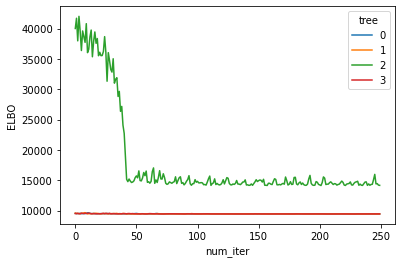

In [7]:
# add mutation and select the best tree(s)
t.sel_mutation(initial = True)
t.select_tree(num_iter = 300, init = 50)

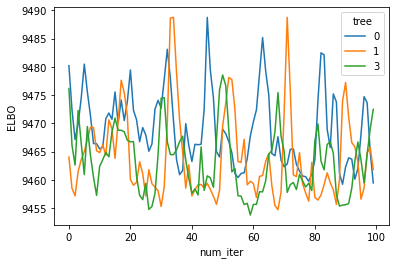

In [8]:
t.print_elbo(300, 200, include = t.tree_indices)

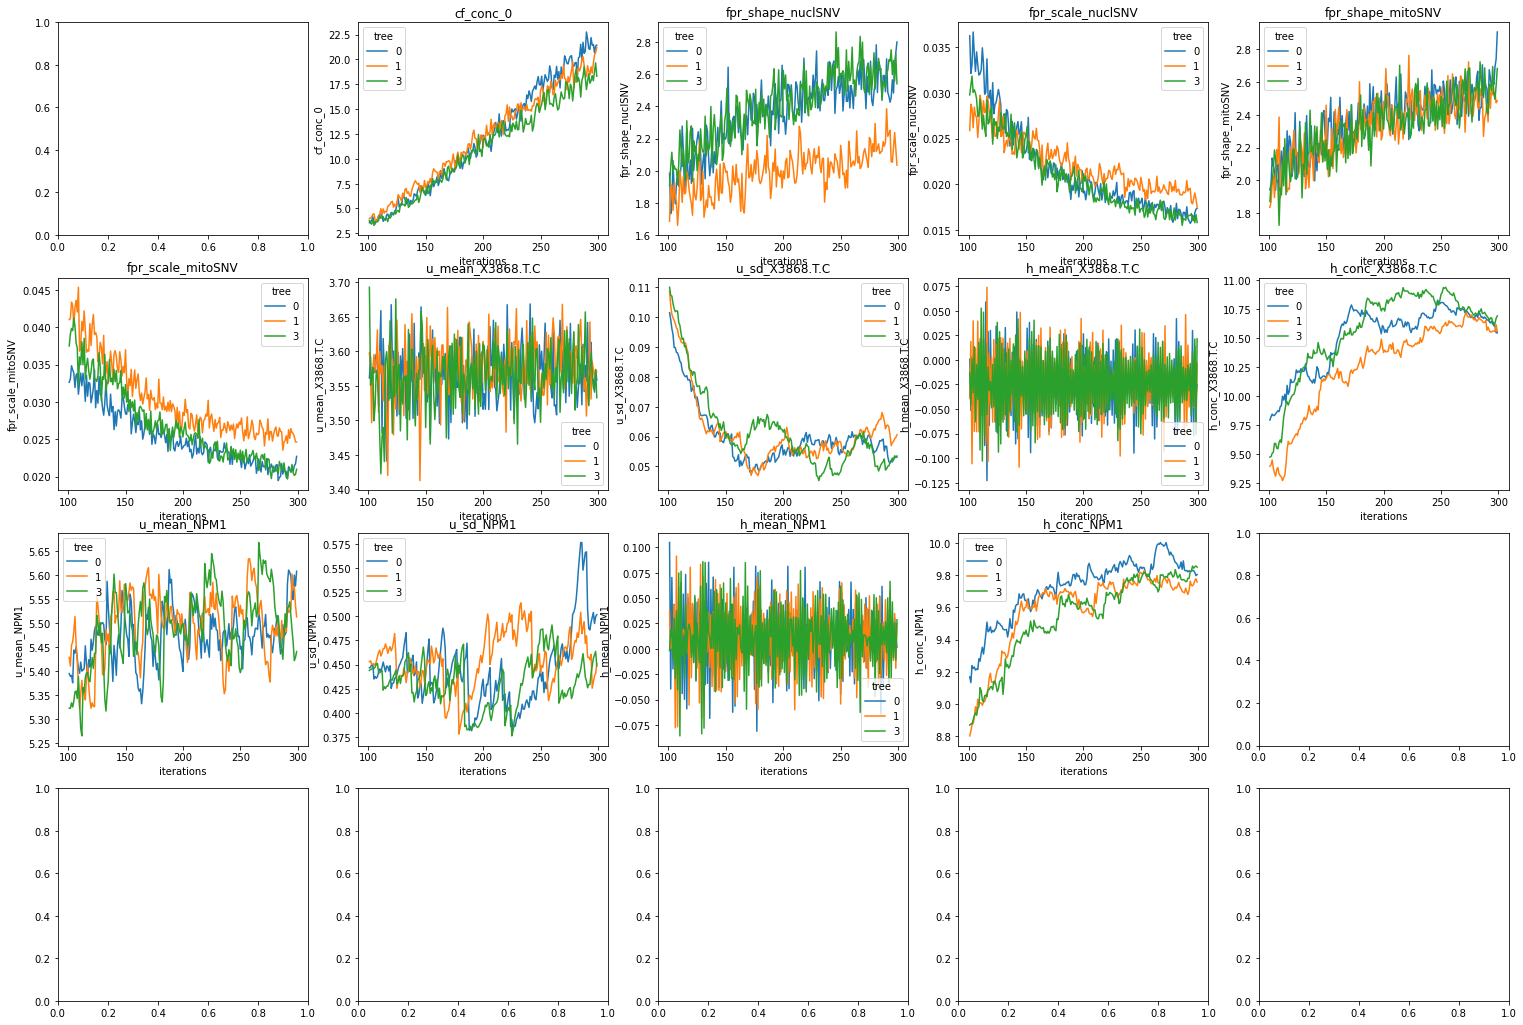

In [9]:
t.print_params(include = t.tree_indices, it = 100)

Apparently the FPR for NPM1 is much higher (similar levels to the mitochondrial FPR)

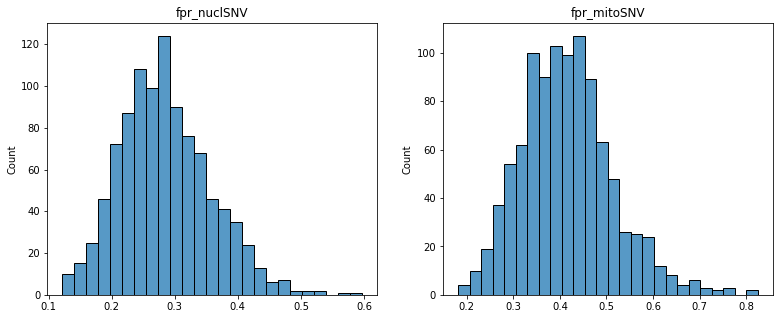

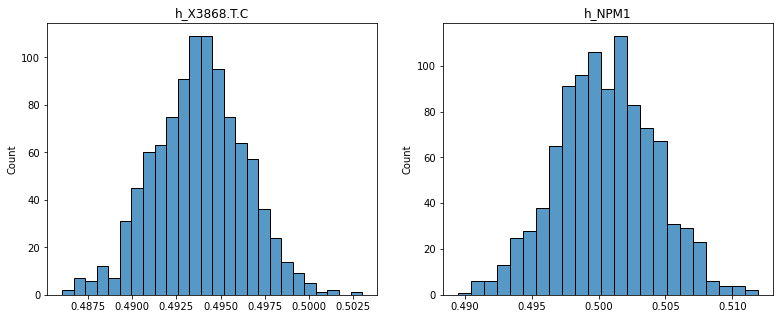

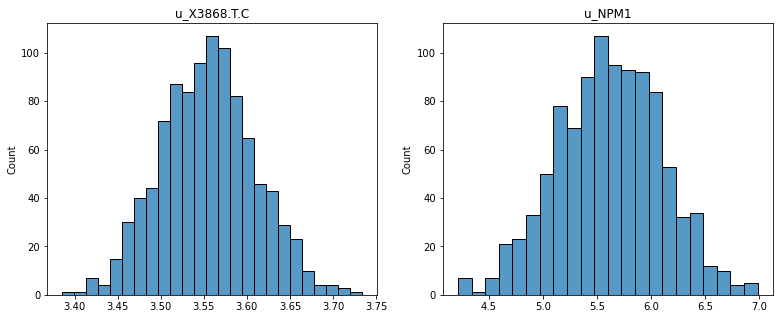

In [10]:
t.plot_posterior("all", 0, 1000)

## Add DNMT3A

DNMT3A added to the tree
Choosing best tree among 18 potential candidates
Model fit to tree 0 in 0m 54s
Model fit to tree 1 in 1m 3s
Model fit to tree 2 in 0m 56s
Model fit to tree 3 in 0m 56s
Model fit to tree 4 in 1m 3s
Model fit to tree 5 in 0m 59s
Model fit to tree 6 in 0m 58s
Model fit to tree 7 in 1m 3s
Model fit to tree 8 in 0m 59s
Model fit to tree 9 in 1m 1s
Model fit to tree 10 in 1m 5s
Model fit to tree 11 in 1m 5s
Model fit to tree 12 in 0m 59s
Model fit to tree 13 in 1m 9s
Model fit to tree 14 in 1m 4s
Model fit to tree 15 in 1m 9s
Model fit to tree 16 in 1m 0s
Model fit to tree 17 in 0m 53s
Trees [1, 8, 9, 12, 15] selected for mutations ['X3868.T.C', 'NPM1', 'DNMT3A']
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [1., 1., 1.]

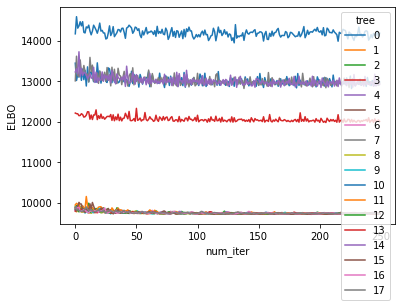

In [11]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 300, init = 50)

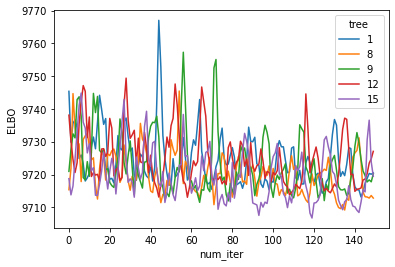

In [12]:
t.print_elbo(num_iter = 300, init = 150, include = t.tree_indices)

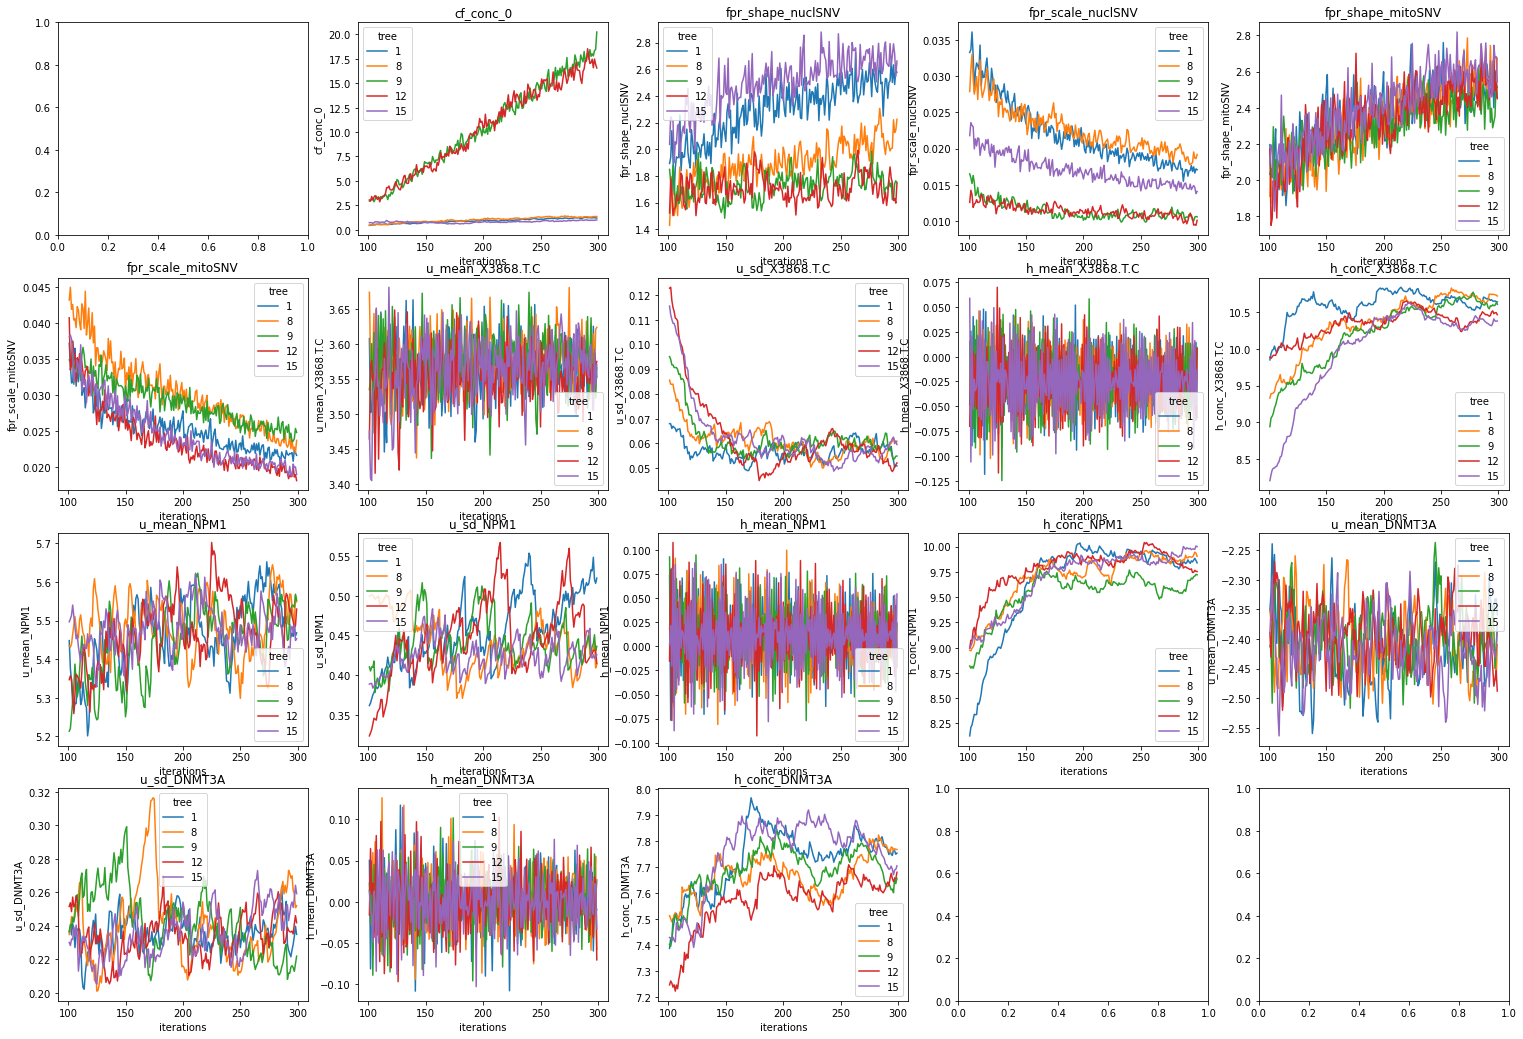

In [13]:
t.print_params(include = t.tree_indices, it = 100)

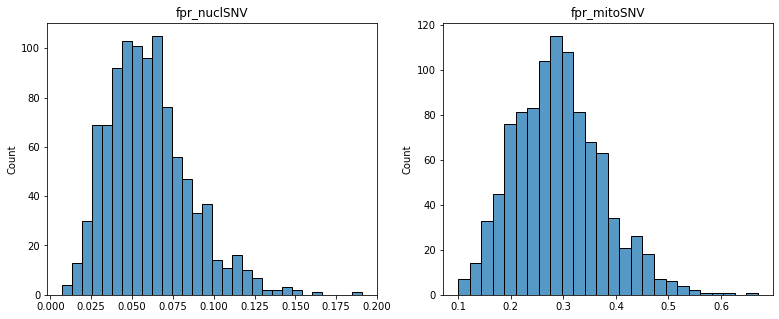

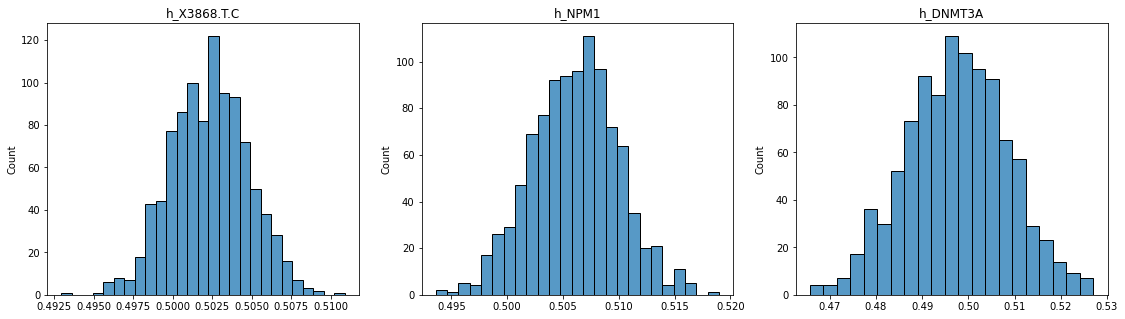

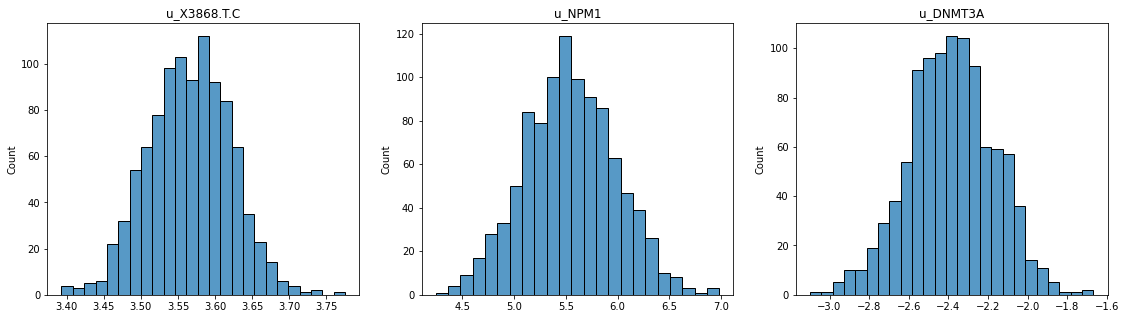

In [15]:
t.plot_posterior("all", 9, 1000)

In [ ]:
t.plot_posterior("all", 6, 1000)

# Infer Clonal assignment probabilities

In [20]:
t.clonal_assignment(tree = 4)

Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 1m and 8s


In [21]:
t.clone_probs

{0: tensor([[5.2438e-05, 5.2575e-05, 4.8475e-04, 9.9941e-01],
         [8.7327e-05, 8.7826e-05, 1.7171e-03, 9.9811e-01],
         [2.1595e-04, 2.2054e-04, 1.4799e-03, 9.9808e-01],
         ...,
         [4.0824e-03, 1.3692e-02, 4.1903e-03, 9.7804e-01],
         [8.2986e-05, 8.3440e-05, 3.9995e-03, 9.9583e-01],
         [5.1452e-05, 5.1603e-05, 4.1918e-03, 9.9571e-01]],
        grad_fn=<DivBackward0>),
 4: tensor([[7.3235e-05, 7.3459e-05, 9.9985e-01],
         [1.1713e-04, 1.1782e-04, 9.9977e-01],
         [2.9183e-04, 2.9852e-04, 9.9941e-01],
         ...,
         [5.4557e-03, 1.6726e-02, 9.7782e-01],
         [1.0375e-04, 1.0427e-04, 9.9979e-01],
         [6.3680e-05, 6.3843e-05, 9.9987e-01]], grad_fn=<DivBackward0>)}

In [18]:
t.params_post

{1: {'cf_conc': array([  1.19365624,  19.96657746,   0.67228836, 483.10993555]),
  'fpr_shape_nuclSNV': array(2.57781133),
  'fpr_scale_nuclSNV': array(0.01707322),
  'fpr_shape_mitoSNV': array(2.51085184),
  'fpr_scale_mitoSNV': array(0.02164986),
  'u_mean_X3868.T.C': array(3.55324216),
  'u_sd_X3868.T.C': array(0.05090731),
  'h_mean_X3868.T.C': array(-0.06146096),
  'h_conc_X3868.T.C': array(10.60388267),
  'u_mean_NPM1': array(5.46814677),
  'u_sd_NPM1': array(0.5223653),
  'h_mean_NPM1': array(-0.01344486),
  'h_conc_NPM1': array(9.83857324),
  'u_mean_DNMT3A': array(-2.3590792),
  'u_sd_DNMT3A': array(0.2349037),
  'h_mean_DNMT3A': array(0.026407),
  'h_conc_DNMT3A': array(7.75304975),
  'cf': array([0.00236395, 0.03954228, 0.00133142, 0.95676236]),
  'af': array([0.47904689, 0.47838118, 0.49881803])},
 8: {'cf_conc': array([  1.35317857,  16.81873699,   2.92498739, 422.38016864]),
  'fpr_shape_nuclSNV': array(2.224727),
  'fpr_scale_nuclSNV': array(0.01917853),
  'fpr_shape_mit

In [40]:
t.N

tensor([[ 0., 18., 45.],
        [ 0.,  5., 49.],
        [ 0.,  4., 15.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0., 23.],
        [ 0.,  0., 72.]])

In [41]:
t.params_post

{13: {'cf_conc': array([ 16.3293432 ,   6.84012407, 204.01089701, 357.40807289]),
  'u_mean_nuclSNV': array(3.59668272),
  'u_sd_nuclSNV': array(0.14944271),
  'fpr_shape_nuclSNV': array(0.8829645),
  'fpr_scale_nuclSNV': array(0.00214826),
  'u_mean_mitoSNV': array(3.5633292),
  'u_sd_mitoSNV': array(0.05512808),
  'fpr_shape_mitoSNV': array(2.70374297),
  'fpr_scale_mitoSNV': array(0.02248915),
  'h_mean_X3868.T.C': array(-0.03942946),
  'h_conc_X3868.T.C': array(10.33169502),
  'h_mean_NPM1': array(0.00977372),
  'h_conc_NPM1': array(9.48830574),
  'h_mean_DNMT3A': array(0.49895498),
  'h_conc_DNMT3A': array(8.04803436),
  'cf': tensor([0.0279, 0.0117, 0.3490, 0.6114]),
  'af': tensor([0.4802, 0.4860, 0.3057])}}

In [19]:
t.export_pickle("svi_objects/P80.pickle")

Tree object saved as pickle!


In [38]:
with open("svi_objects/P80.pickle", 'rb') as f:
    test = pickle.load(f)